# How did First Time Buyers’ (FTB) Relief impact housing prices of different property types?

## Introduction

The Great Recession in 2008 demonstrated how changes to the housing market have not only economic but also social consequences. John Bone and Karen O'Reilly (2010) suggest that the recent trend of viewing the purchase of property as a means of investment rather than a primary place to live contributes to growing housing unaffordability. This socio-economic issue specifically concerns younger people who do not come from a privileged background and do not have substantial savings to enter the housing market. According to Nissa Finney and Albert Sabater(2022), as housing in certain areas of England and Wales becomes less affordable, it causes a generational divide in housing opportunities. Age segregation becomes more prominent, presenting challenges to social mobility.

Additionally, John Bone and Karen O'Reilly (2010) mention how a larger number of individuals owning a stable home results in more sustainable communities and benefits the overall wellbeing of many families. According to Nikodem Szumilo (2018), accessible homeownership would not necessarily change wages but might potentially have positive implications for increased economic activity. Therefore, governments should consider how their policies affect demand and supply in the housing market. In 2017, the UK government announced a new policy, the First Time Buyers' (FTB) Relief, which exempted buyers from paying a Stamp Duty Land Tax (SDLT) on an acquired house with a value of less than 300 thousand pounds and removed property tax from house purchases valued less than 500 thousand. This policy should have increased affordability for those who considered buying their first home (Bolster, 2011).

This analysis uses the data provided by HM Land Registry, the non-ministerial department that monitors and documents every housing transaction in England and Wales and has an open database for all purchases since 1995(HM Land Registry Open Data, 2023). This research paper attempts to evaluate how the FTB Relief influenced market prices and what difference it made for properties of different ages, types, and estates. Therefore, the exploration is limited to only 5 years with all property transactions between March 2015 and March 2020, as the COVID-19 pandemic disrupted the economy overall. This research focuses on the Greater London area, the most populated English county that accounts for almost 13% of all property transactions in England and Wales.

This paper highlights how prices of detached houses purchased are substantially more expensive and the average is more volatile compared to other types of property between March 2015 and March 2020. Most of the property purchased in Greater London had a price of less than 600 thousand pounds. Within the same time period, the mean housing price increased every year, except for a year between March 2018 and March 2019, which experienced a significant price drop. The comparison for growth rates in prices between old and new property demonstrates that there was an increase in the values of new property purchased for the last 3 years, with a spike in growth between March 2017 and March 2018.


## Data Cleaning

The dataset used in this research includes 16 variables: Transaction Identifier (each purchase has a unique value), Price Paid, Date of Transfer, Postcode, Property Type, New Build status, Tenure, Primary Address (PAON), Secondary Address (SAON), Street, Locality, City or Town, District, County, PPD_Category Type, and Record Status(HM Land Registry Open Data, 2023). All address variables indicate the location of the sold property. Property Type specifies if it's a flat (F), detached (D), semi-detached (S), or terraced (T) house, or other type of property (O). Tenure ('Duration') can be freehold (F) or leasehold (L), a trait common in the housing market of common law countries. PPD_Category indicates whether the purchase was a Standard Price Paid entry (A) or an Additional Price Paid entry (B).

The research question focuses on the period from March 2015 to March 2020, so transactions outside this timeframe are excluded. The analysis is centered on residential properties, thus only transactions for detached, semi-detached, terraced houses, and flats are considered. The filtering process removes PAON, SAON, and Record Status columns, and data where the Tenure type is unknown, as they are irrelevant to the research question. It also excludes all purchases made outside of the Greater London Area, as it is the primary region of interest.

For this research, changes in the Greater London Area's housing market can be analyzed through changes in property prices, thereby making it the dependent variable. Independent variables that could potentially affect it include Date of Transfer, Property Type, Tenure, and Old/New (property age). All entries with missing price values are removed, however, there are none.

These variables are significant in this research because they could potentially indicate different dynamics based on socio-economic factors, as areas typically have a higher concentration of specific housing types. This also expands the potential for future research.

In [60]:
import numpy as np
import pandas as pd 
import os

In [61]:
dataset_path = "/Users/user/Desktop/ECO225/ECO225Project/Data02304.csv"

colnames = ['Transaction_unique_identifier', 'price', 'Date_of_Transfer', 
            'postcode', 'Property_Type', 'Old/New', 
            'Duration', 'PAON', 'SAON', 
            'Street', 'Locality', 'Town/City', 
            'District', 'County', 'PPDCategory_Type',
            'Record_Status - monthly_file_only']

In [154]:
# Read the dataset in chunks
chunk_size = 10000
df_chunks = pd.read_csv(dataset_path, header=None, names=colnames, chunksize=chunk_size)

In [155]:
#Convert "Date_of_Transfer" to year and month
df = pd.concat([chunk.assign(Year_of_Transfer=pd.to_datetime(chunk['Date_of_Transfer']).dt.year,
                             Month_of_Transfer=pd.to_datetime(chunk['Date_of_Transfer']).dt.month) 
                for chunk in df_chunks])

In [156]:
df = df[((df['Year_of_Transfer'] == 2015) & (df['Month_of_Transfer'] >= 3)) |
        ((df['Year_of_Transfer'] > 2015) & (df['Year_of_Transfer'] < 2020)) |
        ((df['Year_of_Transfer'] == 2020) & (df['Month_of_Transfer'] < 3))]

In [184]:
# Remove unnecessary columns
df_copy = df.copy()
columns_to_remove = ['PAON', 'SAON', 'Record_Status - monthly_file_only']
df_copy = df_copy.drop(columns=columns_to_remove)
df_copy = df_copy[(df_copy['Duration'] != 'U')]

In [185]:
df_copy['Date_of_Transfer'] = pd.to_datetime(df_copy['Date_of_Transfer'])
reference_date = pd.to_datetime('2017-11-22') #date when policy was implemented
# Create the 'Before/After' variable
df_copy['Before/After'] = df_copy['Date_of_Transfer'].apply(lambda x: 'Before' if x < reference_date else 'After')

In [186]:
property_types_to_keep = ['D', 'S', 'T', 'F']

In [187]:
df_cardiff = df_copy[df_copy['Property_Type'].isin(property_types_to_keep) & (df_copy['County'] == 'CARDIFF')]

In [188]:
df_copy = df_copy[df_copy['Property_Type'].isin(property_types_to_keep) & (df_copy['County'] == 'GREATER LONDON')]

In [189]:
groupby_vars = ['Property_Type', 'Old/New', 'Duration', 'Year_of_Transfer', 'Month_of_Transfer', 'Before/After']

In [191]:
#Create summary statistics

intervals = [
    ((2015, 3), (2016, 2)),
    ((2016, 3), (2017, 2)),
    ((2017, 3), (2018, 2)),
    ((2018, 3), (2019, 2)),
    ((2019, 3), (2020, 2))
]

In [192]:
# Function to determine the interval name for a given year and month
def get_interval_name(start_year, end_year):
    return f"March {start_year} - February {end_year}"

In [193]:
# Function to determine the interval for a given year and month
def get_interval(year, month):
    for i, ((start_year, start_month), (end_year, end_month)) in enumerate(intervals):
        if (year > start_year or (year == start_year and month >= start_month)) and \
           (year < end_year or (year == end_year and month <= end_month)):
            return get_interval_name(start_year, end_year)

In [194]:
# Apply the interval calculation to the DataFrame
df_copy['Interval'] = df_copy.apply(lambda x: get_interval(x['Year_of_Transfer'], x['Month_of_Transfer']), axis=1)
#DO NOT TOUCH DF GROUP ANYMORE

## Summary Statistics Table

In [196]:
# Group by Interval, Property_Type, Duration, and Old/New
grouped_df = df_copy.groupby(['Before/After', 'County'])['price'].describe()

# Reset index to make Interval and other columns
grouped_df.reset_index(inplace=True)

# Rename columns for consistency
grouped_df.rename(columns={'mean': 'Price_Mean', '50%': 'Price_Median', 'std': 'Price_Std (Thousand £)', 'count': 'Price_Count'}, inplace=True)
grouped_df['Price_Std (Thousand £)'] /= 1000
grouped_df = pd.DataFrame(grouped_df)



# Group by Interval, Property_Type, Duration, and Old/New
grouped_df_cardiff = df_cardiff.groupby(['Before/After', 'County'])['price'].describe()

# Reset index to make Interval and other columns
grouped_df_cardiff.reset_index(inplace=True)

# Rename columns for consistency
grouped_df_cardiff.rename(columns={'mean': 'Price_Mean', '50%': 'Price_Median', 'std': 'Price_Std (Thousand £)', 'count': 'Price_Count'}, inplace=True)
grouped_df_cardiff['Price_Std (Thousand £)'] /= 1000
grouped_df_cardiff = pd.DataFrame(grouped_df_cardiff)
grouped_df

,Before/After,County,Price_Count,Price_Mean,Price_Std (Thousand £),min,25%,Price_Median,75%,max
0,After,GREATER LONDON,229825.0,619949.810900,927.769237,1.0,342500.0,457000.0,650000.0,160000000.0
1,Before,GREATER LONDON,322228.0,582565.495199,727.417808,400.0,315000.0,430000.0,622500.0,90000000.0


In [197]:
grouped_df_cardiff

,Before/After,County,Price_Count,Price_Mean,Price_Std (Thousand £),min,25%,Price_Median,75%,max
0,After,CARDIFF,13880.0,232574.135014,125.541138,500.0,150000.0,200000.0,280000.0,2000000.0
1,Before,CARDIFF,16308.0,210465.429789,118.257204,6500.0,135000.0,177652.5,250000.0,1500000.0


The data is organized into intervals spanning from March of one year to February of the next year, allowing for separate analysis of each yearly period. Within each interval, summary statistics are calculated for various combinations of property types. For instance, the initial row presents price statistics specifically for old detached freehold properties purchased between March 2015 and February 2016 (inclusive).

Across the dataset, significant price variability is observed, with detached freehold properties typically having on average higher prices compared to flats, which are generally more affordable. Additionally, there appears to be a lower volume of purchases for new properties overall.

However, further conclusions are challenging to make due to the extensive dataset and the presence of numerous independent variables. The mean price indicates the average value of a particular property type acquired during the interval, while the median signifies the 50th percentile threshold. Maximum and Minimum values demonstrate lowest and highest price paid for that type of property during specific interval, however, it highly varies. For example, some purchases had a price of a few millions, whereas some price paid are less than 10 thousand pounds.

Variablity can be observed thorugh all values of summary statistics, demonstrating rapid changes to the housing market in Greater London Area. The following visualisations helps to explore these tendencies further.

## Plots, Histograms, Figures

In [210]:
import pandas as pd
import matplotlib.pyplot as plt

df_difference = pd.concat([df_cardiff, df_copy])
group_means = df_difference.groupby(['County', 'Before/After'])['price'].mean().unstack()
group_means['Difference'] = group_means['After'] - group_means['Before']
group_means
diff_in_diff = group_means.loc['GREATER LONDON', 'Difference'] - group_means.loc['CARDIFF', 'Difference']
print(group_means)
print("\nDifference in Difference between counties:", diff_in_diff)

Before/After            After         Before    Difference
County                                                    
CARDIFF         232574.135014  210465.429789  22108.705225
GREATER LONDON  619949.810900  582565.495199  37384.315701

Difference in Difference between counties: 15275.61047519726


<Figure size 1000x600 with 0 Axes>

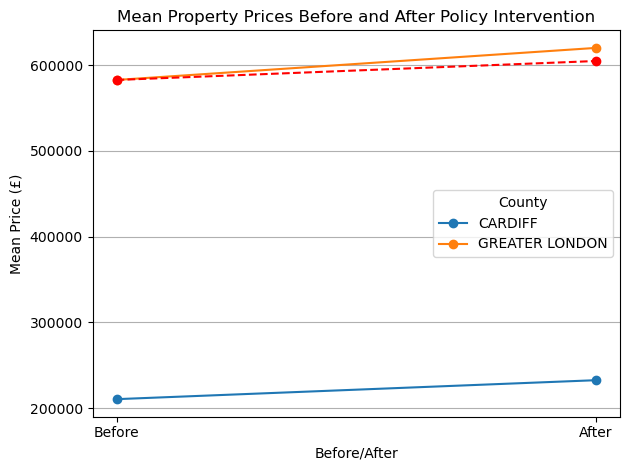

In [200]:
# Plot the mean prices for Cardiff and Greater London before and after the policy intervention
plt.figure(figsize=(10, 6))
group_means[['Before', 'After']].T.plot(marker='o', linestyle='-')
plt.title('Mean Property Prices Before and After Policy Intervention')
plt.xlabel('Before/After')
plt.ylabel('Mean Price (£)')
plt.xticks([0, 1], ['Before', 'After'])  # Setting custom x-axis ticks

# Plot the dashed line for Greater London with the same price change as Cardiff
greater_london_before = group_means.loc['GREATER LONDON', 'Before']
cardiff_difference = group_means.loc['CARDIFF', 'Difference']

# Define the y-coordinates of the points
y_values = [greater_london_before, greater_london_before + cardiff_difference]

# Plot the points
plt.plot([0], [greater_london_before], marker='o', linestyle='-', color='red', label='Before')
plt.plot([1], [greater_london_before + cardiff_difference], marker='o', linestyle='-', color='red', label='After')

# Connect the points with a line
plt.plot([0, 1], y_values, linestyle='--', color='red')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [17]:
import matplotlib.pyplot as plt

In [18]:
%matplotlib inline

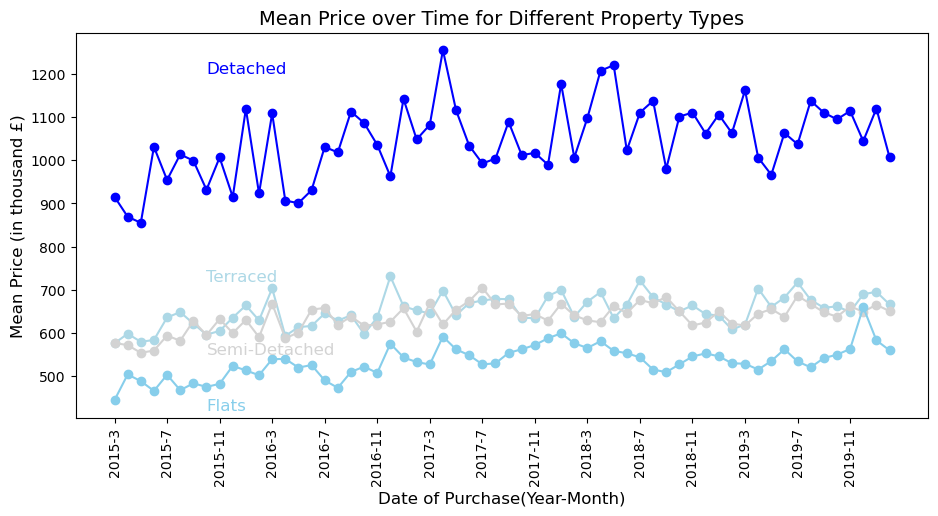

In [221]:
def plot_mean_price_over_time(df, property_types_to_keep, ax):
    color_map = {'D': 'blue', 'E': 'lightblue', 'F': 'skyblue', 'S': '#D3D3D3'}
    # Loop over each property type
    for prop_type in property_types_to_keep:
        df_filtered = df_copy[df_copy['Property_Type'] == prop_type].copy()
        # Convert 'Date_of_Transfer' to datetime
        df_filtered['Date_of_Transfer'] = pd.to_datetime(df_filtered['Date_of_Transfer'])
        # Extract year and month from 'Date_of_Transfer'
        df_filtered['Year'] = df_filtered['Date_of_Transfer'].dt.year
        df_filtered['Month'] = df_filtered['Date_of_Transfer'].dt.month
        # Group by year and month, calculate the mean price for each group
        grouped_df = df_filtered.groupby(['Year', 'Month'])['price'].mean().reset_index()
        # Convert price to thousands of pounds
        grouped_df['price'] /= 1000
        line_color = color_map.get(prop_type, 'lightblue')  
        ax.plot(grouped_df['Year'].astype(str) + '-' + grouped_df['Month'].astype(str), grouped_df['price'], marker='o', linestyle='-', label=prop_type, color=line_color)
        # Add labels on the lines
        if prop_type == 'D':
            ax.text('2015-10', 1200, 'Detached', fontsize=12, color=line_color)
        elif prop_type == 'T':
            ax.text('2015-10', 720, 'Terraced', fontsize=12, color=line_color)
        elif prop_type == 'S':
            ax.text('2015-10', 550, 'Semi-Detached', fontsize=12, color=line_color)
        elif prop_type == 'F':
            ax.text('2015-10', 420, 'Flats', fontsize=12, color=line_color)
    ax.set_xlabel('Date of Purchase(Year-Month)', fontsize=12)  # Reduced fontsize for axis label
    ax.set_ylabel('Mean Price (in thousand £)', fontsize=12)  # Reduced fontsize for axis label
    ax.set_title('Mean Price over Time for Different Property Types', fontsize=14)  # Reduced fontsize for title
    ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels
    ax.set_xticks(ax.get_xticks()[::4])
fig, ax = plt.subplots(figsize=(11, 5))
plot_mean_price_over_time(df, ['D', 'T', 'S', 'F'], ax)
plt.show()

This graph displays the average price of property sold for different types of housing. The figure clearly indicates that Detached houses are usually more expensive and purchase values experience more volatility if one compares them to Flats, Semi-detached or Terraced houses. The average price mostly increase from March 2016 and peaks in March 2017. There is another spike for detached houses between November 2017 and May 2018. There is little difference between Terraced and Semi-Detached Houses, however, Flats were sold at the lowest price on average.

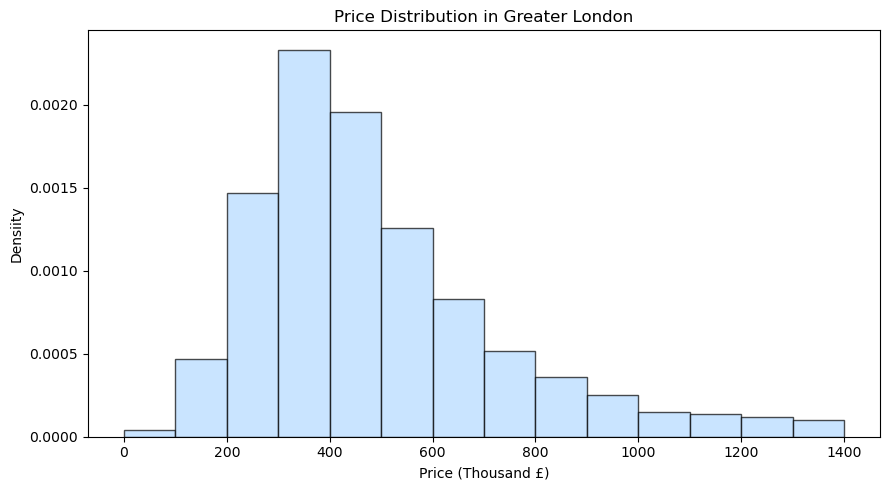

In [222]:
# Determine the 95th percentile of prices to identify outliers
price_95th_percentile = df_copy['price'].quantile(0.95)
# Filter the DataFrame to exclude outliers
df_filtered = df_copy[df_copy['price'] <= price_95th_percentile].copy()  # Ensure copy of DataFrame is made
# Convert prices to thousands for the filtered data
df_filtered.loc[:, 'price_thousands'] = df_filtered['price'] / 1000  # Use .loc[] for assignment
# Determine the minimum and maximum prices in the filtered dataset (in thousands)
min_price = df_filtered['price_thousands'].min()
max_price = df_filtered['price_thousands'].max()
bin_edges = list(range(int(min_price), int(max_price) + 100, 100)) 
plt.figure(figsize=(9, 5))
plt.hist(df_filtered['price_thousands'], bins=bin_edges, color='#b3d9ff', edgecolor='black', alpha=0.7, density=True)
plt.xlabel('Price (Thousand £)')
plt.ylabel('Densiity')
plt.title('Price Distribution in Greater London')
plt.tight_layout()
plt.show()

This figure clearly displays distribution of property prices that were sold just in Greater London Area between March 2015 and March 2020. The chart is definitely skewed to the right and indicates that most purchases were lower than median and under the value of 800 thousand pounds. The spike in the price range between 300 and 400 thousand pounds indicates that this was the most frequent value paid for the property.

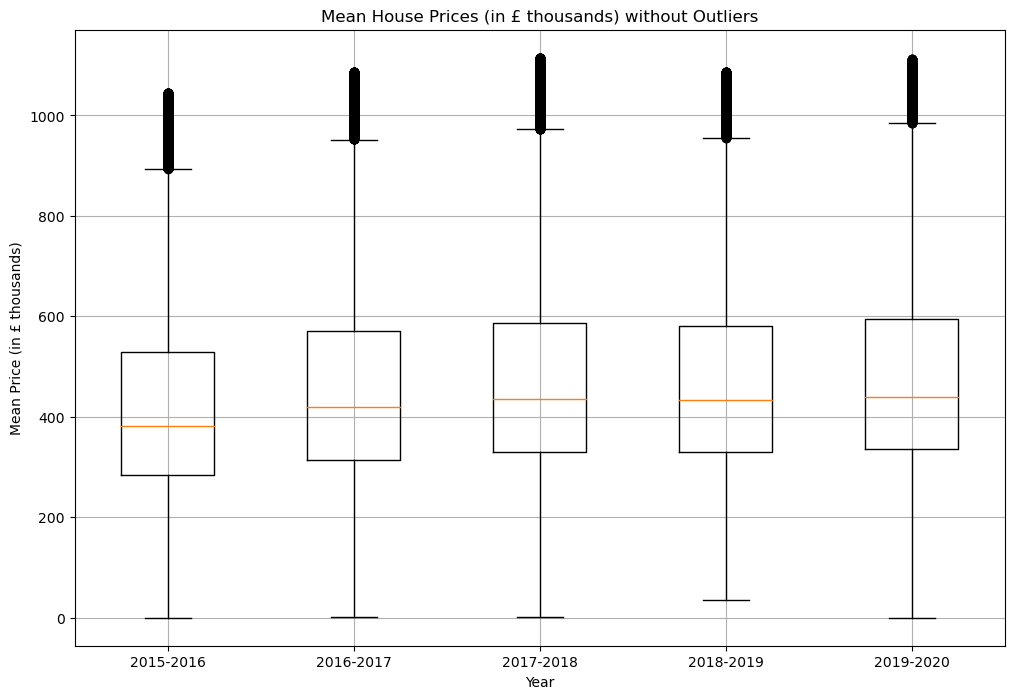

In [257]:
import matplotlib.pyplot as plt
import numpy as np

# List of interval labels
interval_labels = ['March 2015 - February 2016',
                   'March 2016 - February 2017',
                   'March 2017 - February 2018',
                   'March 2018 - February 2019',
                   'March 2019 - February 2020']

# Initialize an empty list to store all data without outliers
all_data_no_outliers = []
years = []

# Loop over each interval
for interval_label in interval_labels:
    # Filter the DataFrame for the specified interval
    df_interval = df_copy[df_copy['Interval'] == interval_label]
    years.append(interval_label.split()[1]+ '-'+ interval_label.split()[4])
    # Extract the price data for the interval and divide by 1000
    data = df_interval['price'] / 1000  # Divide by 1000 to convert to thousands of pounds

    # Calculate the first and third quartiles
    q1, q3 = np.percentile(data, [25, 75])

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Define the lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Remove outliers from the data
    data_no_outliers = data[(data >= lower_bound) & (data <= upper_bound)]

    # Add data without outliers to the list
    all_data_no_outliers.append(data_no_outliers)

# Create the box plot with all intervals on the same graph
plt.figure(figsize=(12, 8))
plt.boxplot(all_data_no_outliers, labels=years)  # Use years for x-axis labels

# Add title, labels, and grid
plt.title('Mean House Prices (in £ thousands) without Outliers')
plt.xlabel('Year')
plt.ylabel('Mean Price (in £ thousands)')
plt.grid(True)

# Show the plot
plt.show()

This box plot demonstrates general change in the prices of the property sold based on intervals and independent of other variables. The average price of property sold increased each year, except time period between March 2018 and March 2019, when it clearly dropped. There was more variability in prices paid between March 2015 and March 2016 compared to other years, whereas time periods between 2016 and 2017 or 2018 and 2019 indicate that monthly average prices paid are closer to the median values. All values fall in range between 550 and 650 thousand pounds.

In [290]:
# Calculate percentage change of mean price from one interval to the other
grouped_df = df_copy.groupby(['Property_Type', 'Before/After', 'Old/New'])

# Calculate the mean price for each group
mean_price = grouped_df['price'].mean()

# Unstack the 'Before/After' level to pivot it into columns
mean_price_unstacked = mean_price.unstack(level='Before/After')

# Calculate the percentage change
percentage_change = ((mean_price_unstacked['After'] - mean_price_unstacked['Before']) / mean_price_unstacked['Before']) * 100

# Rename the Series
percentage_change = percentage_change.rename('Mean_Percent_Change')

# Reset index to get 'Old/New' back as a column
percentage_change = percentage_change.reset_index()

  Property_Type Old/New  Mean_Percent_Change
0             D       N             7.093025
1             D       Y            -0.565981
2             F       N             2.800044
3             F       Y            13.507448
4             S       N             3.607756
5             S       Y            11.639222
6             T       N             4.085289
7             T       Y            19.364214


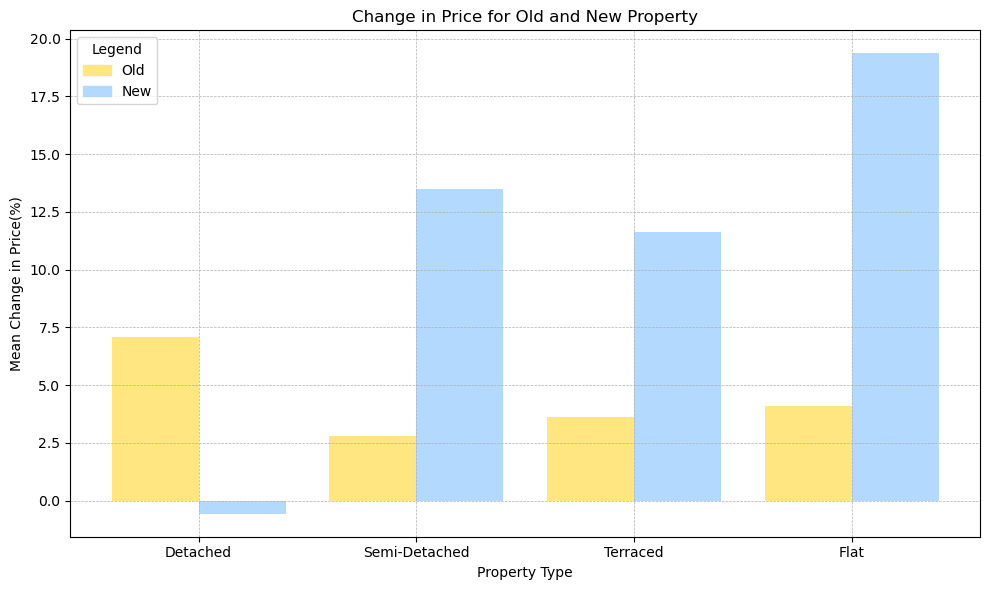

In [294]:
fig, ax = plt.subplots(figsize=(10, 6))
type_order = percentage_change['Property_Type'].unique()
age = percentage_change['Old/New'].unique()

# Set colors for N and Y bars
colors = {'Y': '#b3d9ff', 'N': '#ffe680'}

bar_width = 0.4

for i in range(len(type_order)):
    p_type = type_order[i]
    p_data = percentage_change[percentage_change['Property_Type'] == p_type]
    n_values = p_data[p_data['Old/New'] == 'N']['Mean_Percent_Change'].values
    y_values = p_data[p_data['Old/New'] == 'Y']['Mean_Percent_Change'].values
    ax.bar([i - bar_width / 2] * len(n_values), n_values, width=bar_width, color=colors['N'], label='Old')
    ax.bar([i + bar_width / 2] * len(y_values), y_values, width=bar_width, color=colors['Y'], label='New')
    
ax.set_xticks(range(len(type_order)))
ax.set_xticklabels(['Detached', 'Semi-Detached', 'Terraced', 'Flat'])

legend_handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in ['N', 'Y']]
ax.legend(legend_handles, ['Old', 'New'], title='Legend')

ax.set_ylabel('Mean Change in Price(%)')
ax.set_xlabel('Property Type')
ax.set_title('Change in Price for Old and New Property')

# Add grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

This graph compares the growth rates for prices of old and new property purchases. When there was a positive change in the price paid for one type of property, the other type experienced a decrease. Newly-built properties have seen the highest spike in prices paid of almost 50% growth between March 2017 and March 2018, with relatively high growth during consecutive intervals, though at a decreasing rate.

In [384]:
import geopandas as gpd

file_path = "/Users/user/Desktop/ECO225/ECO225Project/Data/London-wards-2018/London-wards-2018_ESRI/London_Ward_CityMerged.shp"
district_df = gpd.read_file(file_path)

district_df.head()

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((516401.596 160201.802, 516407.302 16..."
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.464,0.0,"POLYGON ((519552.998 164295.600, 519508.096 16..."
2,Berrylands,E05000401,Kingston upon Thames,E09000021,145.390,0.0,"POLYGON ((518107.499 167303.399, 518114.301 16..."
3,Alexandra,E05000400,Kingston upon Thames,E09000021,268.506,0.0,"POLYGON ((520336.700 165105.498, 520332.198 16..."
4,Beverley,E05000402,Kingston upon Thames,E09000021,187.821,0.0,"POLYGON ((521201.203 169275.505, 521204.303 16..."


In [385]:
print(district_df.columns)

Index(['NAME', 'GSS_CODE', 'DISTRICT', 'LAGSSCODE', 'HECTARES', 'NONLD_AREA',
       'geometry'],
      dtype='object')


In [387]:
df_maps = df_copy.groupby(['Interval', 'District'])['price'].mean()
df_maps = df_maps.reset_index()
df_maps = df_maps.rename(columns={'price': 'Price_Mean', 'District': 'DISTRICT'})
print(df_maps.tail())

                       Interval        DISTRICT     Price_Mean
160  March 2019 - February 2020       SOUTHWARK  657879.756857
161  March 2019 - February 2020          SUTTON  421882.690811
162  March 2019 - February 2020   TOWER HAMLETS  538613.380662
163  March 2019 - February 2020  WALTHAM FOREST  458897.401342
164  March 2019 - February 2020      WANDSWORTH  751739.913993


In [388]:
interval1 = 'March 2015 - February 2016'
interval2 = 'March 2019 - February 2020'
df_interval1 = df_maps[df_maps['Interval'] == interval1]
df_interval2 = df_maps[df_maps['Interval'] == interval2]

# Merge the two DataFrames based on the 'DISTRICT' column
merged_df = pd.merge(df_interval1, df_interval2, on='DISTRICT', suffixes=('_interval1', '_interval2'))

# Calculate the percentage change in price
merged_df['Percentage_Change'] = ((merged_df['Price_Mean_interval2'] - 
                                   merged_df['Price_Mean_interval1']) / merged_df['Price_Mean_interval1']) * 100

# Create a new DataFrame with 'DISTRICT' and 'Percentage_Change' columns
percentage_change_df = merged_df[['DISTRICT', 'Percentage_Change']]

# Display the new DataFrame
print(percentage_change_df)

                  DISTRICT  Percentage_Change
0     BARKING AND DAGENHAM          27.413722
1                   BARNET           8.253015
2                   BEXLEY          23.799058
3                    BRENT           9.622879
4                  BROMLEY          11.766344
5                   CAMDEN           5.597873
6           CITY OF LONDON          27.885740
7      CITY OF WESTMINSTER          29.600804
8                  CROYDON          24.470445
9                   EALING           3.171074
10                 ENFIELD          18.444935
11               GREENWICH          19.351871
12                 HACKNEY          21.432725
13  HAMMERSMITH AND FULHAM          -1.411756
14                HARINGEY          12.682889
15                  HARROW           4.947793
16                HAVERING          21.850249
17              HILLINGDON          10.509855
18                HOUNSLOW           7.719363
19               ISLINGTON           5.545725
20  KENSINGTON AND CHELSEA        

In [389]:
district_df["DISTRICT"] = district_df["DISTRICT"].str.title()
district_df["DISTRICT"] = district_df["DISTRICT"].str.strip()
# Corrected assignment using .loc
percentage_change_df.loc[:, "DISTRICT"] = percentage_change_df["DISTRICT"].str.title()
percentage_change_df.loc[:, "DISTRICT"] = percentage_change_df["DISTRICT"].str.strip()

In [390]:
districts = district_df.merge(percentage_change_df, left_on="DISTRICT", right_on="DISTRICT", how="inner")

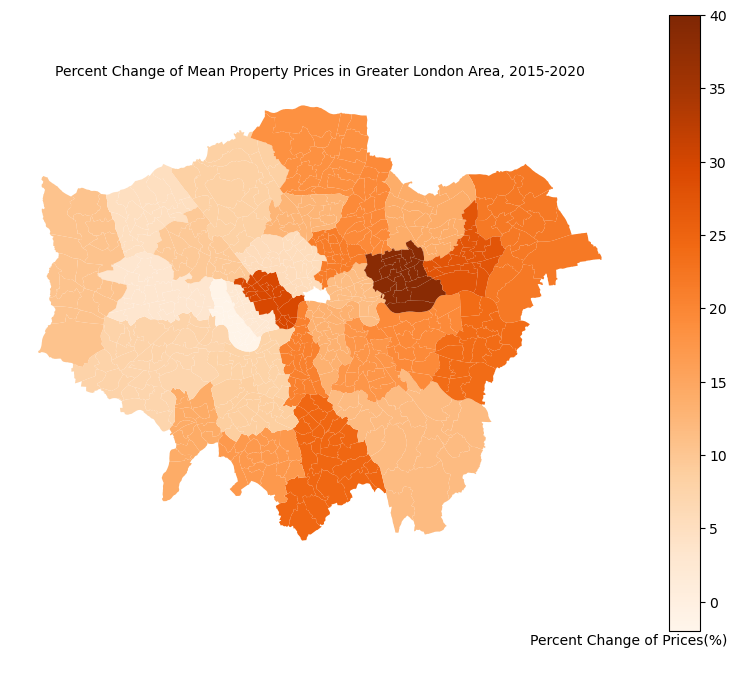

In [396]:
fig, gax = plt.subplots(figsize=(10, 8))

district_df.plot(ax=gax, edgecolor='white', color='white')

districts.plot(
    ax=gax, edgecolor='black', linewidth=0, column='Percentage_Change', legend=True, cmap='Oranges',
    vmin=-2, vmax=40
)


gax.annotate('Percent Change of Prices(%)', xy=(0.53, 0.055), xycoords='figure fraction')
gax.set_title("Percent Change of Mean Property Prices in Greater London Area, 2015-2020", fontsize=10)
plt.axis('off')
plt.show()

In [408]:
total_purchases_district = df_copy.groupby('District').size()
flats_district = df_copy[df_copy['Property_Type'] == 'F'].groupby('District').size()
percentage_flat_district = (flats_district / total_purchases_district) * 100
percentage_flat_district_df = pd.DataFrame({
    'DISTRICT': percentage_flat_district.index,
    'Share of Flats': percentage_flat_district.values
})

# Display the table
print(percentage_flat_district_df)

                  DISTRICT  Share of Flats
0     BARKING AND DAGENHAM       29.700225
1                   BARNET       54.825553
2                   BEXLEY       28.011866
3                    BRENT       63.840976
4                  BROMLEY       36.010131
5                   CAMDEN       84.960756
6           CITY OF LONDON       99.183007
7      CITY OF WESTMINSTER       90.294007
8                  CROYDON       43.869988
9                   EALING       52.945655
10                 ENFIELD       39.818871
11               GREENWICH       59.960120
12                 HACKNEY       83.071034
13  HAMMERSMITH AND FULHAM       74.772672
14                HARINGEY       59.148203
15                  HARROW       46.030004
16                HAVERING       27.039829
17              HILLINGDON       37.772819
18                HOUNSLOW       54.035300
19               ISLINGTON       81.823144
20  KENSINGTON AND CHELSEA       80.792652
21    KINGSTON UPON THAMES       43.339587
22         

In [409]:
district_df["DISTRICT"] = district_df["DISTRICT"].str.title().str.strip()
percentage_flat_district_df["DISTRICT"] = percentage_change_df["DISTRICT"].str.title().str.strip()
districts_flats = district_df.merge(percentage_flat_district_df, left_on="DISTRICT", right_on="DISTRICT", how="inner")
districts_flats

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry,Share of Flats
0,Chessington South,E05000405,Kingston Upon Thames,E09000021,755.173,0.0,"POLYGON ((516401.596 160201.802, 516407.302 16...",43.339587
1,Tolworth and Hook Rise,E05000414,Kingston Upon Thames,E09000021,259.464,0.0,"POLYGON ((519552.998 164295.600, 519508.096 16...",43.339587
2,Berrylands,E05000401,Kingston Upon Thames,E09000021,145.390,0.0,"POLYGON ((518107.499 167303.399, 518114.301 16...",43.339587
3,Alexandra,E05000400,Kingston Upon Thames,E09000021,268.506,0.0,"POLYGON ((520336.700 165105.498, 520332.198 16...",43.339587
4,Beverley,E05000402,Kingston Upon Thames,E09000021,187.821,0.0,"POLYGON ((521201.203 169275.505, 521204.303 16...",43.339587
...,...,...,...,...,...,...,...,...
627,Heath,E05000034,Barking And Dagenham,E09000002,200.128,0.0,"POLYGON ((549410.698 187450.702, 549437.701 18...",29.700225
628,Whalebone,E05000042,Barking And Dagenham,E09000002,155.399,0.0,"POLYGON ((549410.698 187450.702, 549391.199 18...",29.700225
629,Eastbrook,E05000030,Barking And Dagenham,E09000002,345.060,0.0,"POLYGON ((549991.497 184928.504, 549988.899 18...",29.700225
630,Chadwell Heath,E05000029,Barking And Dagenham,E09000002,338.422,0.0,"POLYGON ((548874.200 188496.303, 548843.199 18...",29.700225


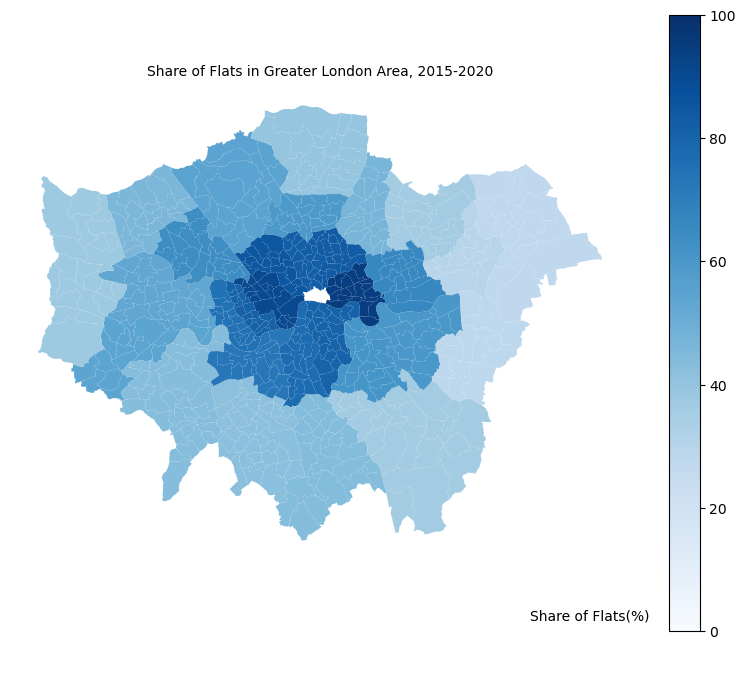

In [416]:
fig, gax = plt.subplots(figsize=(10, 8))

district_df.plot(ax=gax, edgecolor='white', color='white')

districts_flats.plot(
    ax=gax, edgecolor='black', linewidth=0, column='Share of Flats', legend=True, cmap='Blues',
    vmin=0, vmax=100
)


gax.annotate('Share of Flats(%)', xy=(0.53, 0.07), xycoords='figure fraction')
gax.set_title("Share of Flats in Greater London Area, 2015-2020", fontsize=10)
plt.axis('off')
plt.show()

In [419]:
#share of new property sold
new_district = df_copy[df_copy['Old/New'] == 'Y'].groupby('District').size()
percentage_new_district = (new_district / total_purchases_district) * 100
percentage_new_district_df = pd.DataFrame({
    'DISTRICT': percentage_flat_district.index,
    'Percentage of New Property': percentage_new_district.values
})

# Display the table
print(percentage_new_district_df)

                  DISTRICT  Percentage of New Property
0     BARKING AND DAGENHAM                   10.951308
1                   BARNET                   22.839606
2                   BEXLEY                    6.982366
3                    BRENT                   22.528397
4                  BROMLEY                    7.289184
5                   CAMDEN                   15.343067
6           CITY OF LONDON                   36.519608
7      CITY OF WESTMINSTER                   16.961930
8                  CROYDON                   11.902093
9                   EALING                   13.469197
10                 ENFIELD                    4.895229
11               GREENWICH                   28.524427
12                 HACKNEY                   23.188714
13  HAMMERSMITH AND FULHAM                   20.085298
14                HARINGEY                    7.327957
15                  HARROW                   18.477863
16                HAVERING                    8.011613
17        

In [420]:
percentage_new_district_df["DISTRICT"] = percentage_change_df["DISTRICT"].str.title().str.strip()
districts_new = district_df.merge(percentage_new_district_df, left_on="DISTRICT", right_on="DISTRICT", how="inner")
districts_new

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry,Percentage of New Property
0,Chessington South,E05000405,Kingston Upon Thames,E09000021,755.173,0.0,"POLYGON ((516401.596 160201.802, 516407.302 16...",7.342657
1,Tolworth and Hook Rise,E05000414,Kingston Upon Thames,E09000021,259.464,0.0,"POLYGON ((519552.998 164295.600, 519508.096 16...",7.342657
2,Berrylands,E05000401,Kingston Upon Thames,E09000021,145.390,0.0,"POLYGON ((518107.499 167303.399, 518114.301 16...",7.342657
3,Alexandra,E05000400,Kingston Upon Thames,E09000021,268.506,0.0,"POLYGON ((520336.700 165105.498, 520332.198 16...",7.342657
4,Beverley,E05000402,Kingston Upon Thames,E09000021,187.821,0.0,"POLYGON ((521201.203 169275.505, 521204.303 16...",7.342657
...,...,...,...,...,...,...,...,...
627,Heath,E05000034,Barking And Dagenham,E09000002,200.128,0.0,"POLYGON ((549410.698 187450.702, 549437.701 18...",10.951308
628,Whalebone,E05000042,Barking And Dagenham,E09000002,155.399,0.0,"POLYGON ((549410.698 187450.702, 549391.199 18...",10.951308
629,Eastbrook,E05000030,Barking And Dagenham,E09000002,345.060,0.0,"POLYGON ((549991.497 184928.504, 549988.899 18...",10.951308
630,Chadwell Heath,E05000029,Barking And Dagenham,E09000002,338.422,0.0,"POLYGON ((548874.200 188496.303, 548843.199 18...",10.951308


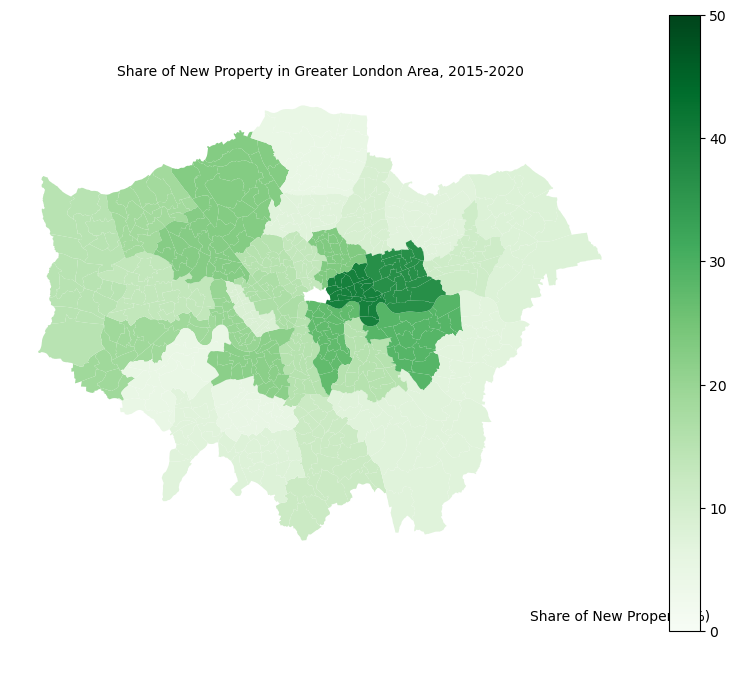

In [424]:
fig, gax = plt.subplots(figsize=(10, 8))

district_df.plot(ax=gax, edgecolor='white', color='white')

districts_new.plot(
    ax=gax, edgecolor='black', linewidth=0, column='Percentage of New Property', legend=True, cmap='Greens',
    vmin=0, vmax=50
)


gax.annotate('Share of New Property(%)', xy=(0.53, 0.07), xycoords='figure fraction')
gax.set_title("Share of New Property in Greater London Area, 2015-2020", fontsize=10)
plt.axis('off')
plt.show()

## Conclusion

In conclusion, this research highlights the nuanced dynamics of the housing market in the Greater London Area before and after the introduction of the First Time Buyers' Relief by the UK government. The analysis underscores significant disparities in price dynamics across property types, with detached houses consistently displaying higher prices compared to flats. While the overall average property prices experienced an upward trend over the five-year interval, a notable decline in mean prices was observed between March 2018 and March 2019. Despite the documentation of several high-value property transactions, the majority of properties sold were valued at less than 800 thousand pounds. These findings underscore the complex nature of housing market dynamics and suggest the need for further exploration to analyse the impact of targeted interventions that address affordability challenges and foster equitable access to housing.

## References

1. Bolster, A. (2011). Evaluating the Impact of Stamp Duty Land Tax First Time Buyer’s Relief.. https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=dbc6dd9a2a
67fcd3e76bd3ed699d3533de147d24
2. Bone, J., & O’Reilly, K. (2010). No place called home: the causes and social consequences of the UK housing 'bubble.' The British Journal of Sociology, 61(2), 231–255. https://doi.org/10.1111/j.1468-4446.2010.01311.x
3. HM Land Registry Open Data. (2023). Landregistry.data.gov.uk. https://landregistry.data.gov.uk/
4. Sabater, A., & Finney, N. (2022). Age segregation and housing unaffordability: Generational divides in housing opportunities and spatial polarisation in England and Wales. Urban Studies. https://doi.org/10.1177/00420980221121088
5. Szumilo, N. (2018). The spatial consequences of the housing affordability crisis in England. Environment and Planning A: Economy and Space, 51(6), 1264–1286. https://doi.org/10.1177/0308518x18811671